# SAE 11 :SE SENSIBILISER A LA CYBERSECURITE. Challenge FTP.

#### Objectifs :  Intercepter une communication FTP afin d'en extraire des informations, à l'aide de scapy (librairie python) et FileZila (client et serveur FTP). Il s'agit d'une attaque "man-in-the-middle".

 Une attaque man-in-the-middle est une cyberattaque s'immisçant entre 2 entités afin d'intercepter les communications et modifier ou voler les données.

##### Dans le cadre de cet SAE, nous avions une capture wireshark intitulé "McDiarmond"

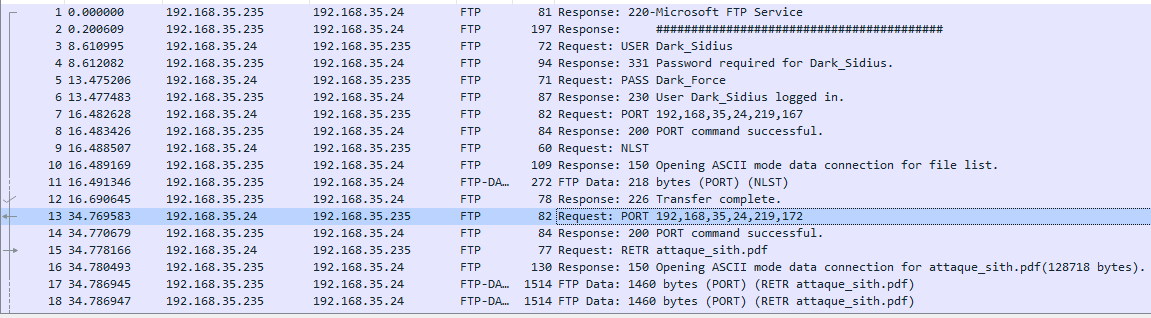

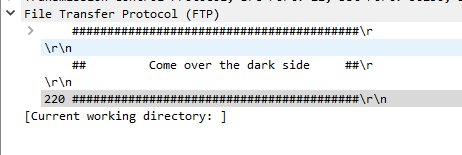

<div class="alert alert-block alert-success">
Analyse du protocole de transfert de fichier FTP
</div>

Le protocole applicatif utilisé est FTP (File Transfer Protocol), utilisé pour transférer des fichiers vers un autre ordinateur du réseau. Ce protocole écoute les informations sur le port 21.

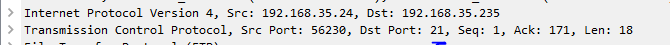

L'adresse ip du client est 192.168.35.24 et l'adresse IP du serveur est 192.168.35.235 (voir ci-dessus)

Le protocol de transport utilisé est TCP. Le port 56230 est utilisé par le protocole TCP. (voir ci-dessus)



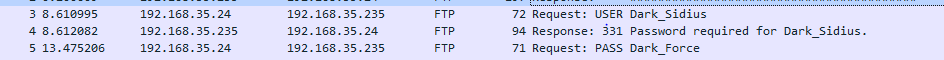

Le username est  Dark_Sidius et le mot de pass est Dark_Force. Ils sont transmis respectivement en clair dans les messages "USER" et "PASS". (voir ci-dessus)

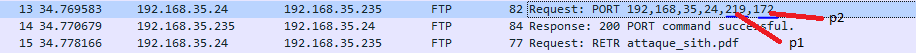

Ici, le port négocié est le port Le calcul est 56236. Le calcul du port port_TCP = p1 * 256 + p2). Avec p1=219 et p2 =172. (voir ci-dessus)

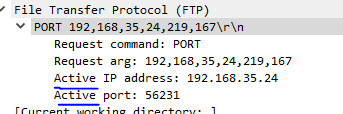

Dans notre trame, FTP utilise le mode actif. Ainsi, c'est le client FTP qui détermine le port de connexion à utiliser pour permettre le transfert des données. (voir ci-dessous)

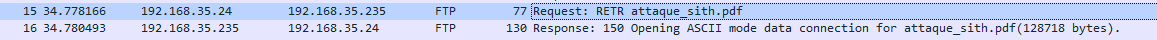

La commande RETR nous indique que le client cherche à télécharger le fichier "attaque_sith.pdf". Ce fichier est de taille 128718 octets. (voir ci-dessus)

Le fichier faisant 128718 bytes, 88 paquets sont transmis avec une taille de 1460bytes chacun car la partie DATA d'une entête IP ne dépasse jamais 1460 bytes.

Le message Transfer Complete nous indique la fin du téléchargement (voir ci-dessus)

<div class="alert alert-block alert-success">
Récupération manuel du login et du mot de passe</div>

Nous allons utiliser la librarie scapy, qui est très utile pour forger, envoyer, réceptionner et manipuler des paquets réseau.
Dans un premier nous chargerons la capture wireshark. Nous savons d'ores et déjà que les paquets[2] et [4] contiennent les informations sur le nom d'utilisateur et le mot de passe. Ainsi, nous décoderons les données brutes en UTF-8 pour une meilleure lecture.

In [1]:
from scapy.all import* #librarie scapy utile pour forger, envoyer, réceptionner et manipuler des paquets réseau.


paquets=rdpcap("McDiarmid.pcapng") #lecture de la trame wireshark
print("La capture comprend les paquets suivants :\n")

k=paquets[2][Raw].load.split(sep=None)[1].decode('UTF8') #On affiche les données (brutes) du paquets 2 et les décode en UTF-8
j=paquets[4][Raw].load.split(sep=None)[1].decode('UTF8') #On affiche les données (brutes) du paquets 4 et les décode en UTF-8
print(f"le nom d'utilisateur est {k} et le mot de passe est {j}")

La capture comprend les paquets suivants :

le nom d'utilisateur est Dark_Sidius et le mot de passe est Dark_Force


<div class="alert alert-block alert-success">
Récupération automatique du login et du mot de passe</div>

Nous snifferons le paquets et nous utiliserons regex afin de chercher à chaque fois que l'expression USER et PASS apparaît,
elle nous affiche le contenu qui la suit afin d'en extraire les username et password.

In [23]:
from scapy.all import * #librairie utile pour forger,analyser et sniffer des paquets
import re # regex va nous permettre d'analyser les expressions régulières

paquets=rdpcap("McDiarmid.pcapng")

def ftp(paquets): #fonction à appliquer à chaque paquet reçu dont  on effectuera les traitements sur les paquets 
    raw = paquets.sprintf('%Raw.load%') #charge les données et va afficher chaque champs en string
    user = re.findall('USER (.*)', raw) #(.*) va afficher toutes les chaines de caractères qui suivent USER dans raw
    pswd = re.findall('PASS (.*)', raw)
    if user:
        print("Le nom d'utilisateur est :",user) 
    elif pswd:
        print("Le mot de passe est :",pswd)    
        
sniff(offline='McDiarmid.pcapng', prn =ftp) #sniffe un paquet en la traitant avec prn qui appelle la fonction ftp


Le nom d'utilisateur est : ["Dark_Sidius\\r\\n'"]
Le mot de passe est : ["Dark_Force\\r\\n'"]


<Sniffed: TCP:110 UDP:0 ICMP:0 Other:0>

<div class="alert alert-block alert-success">
Récupération du fichier transmis à partir du numéro de port TCP et décodage du message
chiffré</div>


FTP transmet les données via le port 20, c'est le moyen le plus simple d'identifier les paquets transportant les données.

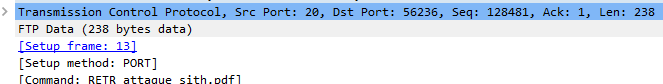


Nous allons écrire sur un fichier à chaque fois qu'un paquet a comme port source numéro 20. Nous écrirons tous les bytes
des données brutes sur le fichier pdf.

In [7]:
from scapy.all import * #librairie utile pour forger,analyser et sniffer des paquets

fichier = open("donnes.pdf","wb") #ouvre le fichier donnes.pdf en écriture en bytes
paquets=rdpcap("McDiarmid.pcapng") #lis la capture wireshark McDiarmid.pcapng

for pkt in paquets:
     if pkt[TCP].sport == 20: #si le port source est égal à 20
        fichier.write(bytes(pkt["Raw"])) #écris en octets tous les paquets contenant les données brutes "Raw"
        

<div class="alert alert-block alert-success">
Décoder les informations du fichier</div>


Nous allons lire le fichier, et nous crérons un dictionnaire qui aura pour chaque clé une lettre.
Ainsi, chaque lettre du message codé sera remplacé par la valeur associé à la clé du dictionnaire. Nous ferons
également attention à la gestion des des retours de ligne.

In [22]:
file = open("donnes.txt","rt") #librairie utile pour forger,analyser et sniffer des paquets
texte = file.read() #lis le fichier

#dictionnaire avec chaque clé associe à une lettre
txt = dict(W='A', S='B', E='C', R='D', D='E', X='F', C='G', F='H', T='I', Y='J', G='K', V='L', B='M', H='N', U='O',
           N='P', J='Q', I='R', O='S', K='T', L='U', M='V', P='W', A='X', Z='Y', Q='Z')


txt2 = [] #tableau pour stocker les nouvelles valeurs de clées

for i in range(len(texte)): 
    if texte[i] in txt.keys(): #si l'indice i de texte appartie à une valeur des clés
        txt2 += txt[texte[i]] #alors ajoute cette valeur à txt2
    else:
        txt2 += texte[i] #sinon garde la même valeur (garder les caractères qui ne sont pas des clés)

for i in range(len(txt2)): #pour i allant jusqu'au tableau de longeur de txt2
    print(txt2[i], end='') #affiche chaque indice de txt2 à la suite, end permet de mettre tous les caractères de la liste sur la même ligne.
   

<class 'str'>
<class 'str'>
DARK SIDIOUS
NOUS DEVONS ECRASER LES JEDI ET TOUTES LES PERSONNES QUI LES
SUPPORTENT. IL EST TEMPS DE FRAPPER UN GRAND COUP ET FAIRE
COMPRENDRE A NOS ENNEMIS QU'ILS DOIVENT SE SOUMETTRE A NOTRE
PUISSANCE.
REJOINS NOTRE FLOTTE DANS LE SYSTEME DE LA BORDURE MEDIANE
DANS TROIS JOURS ET MENE UNE ATTAQUE CONTRE LA PLANETE ANDO.
IL NE DOIT PLUS RESTER AUCUN SURVIVANT SUR CETTE PLANETE ET
LA RACE AQUALISH DOIT DISPARAITRE.
DE PLUS LE JEDI DONT JE TE JOINS LA PHOTO EST UN JEDI R&T. IL A
DES QUALITES EXCEPTIONNELLES POUR L'INTERCEPTION DES
COMMUNICATIONS. TU DOIS LE TUER.
SOIS SANS PITIE.
DARK PLAGEUIS

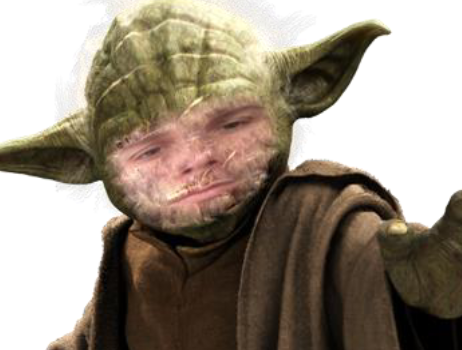
Maître Guillemin.

<div class="alert alert-block alert-success">
Client et serveur FileZilla entre les 2 ordinateurs</div>

Pour la suite de la SAE, nous avons utiliser Filezilla afin de paramétrer le client FTP et le serveur FTP.

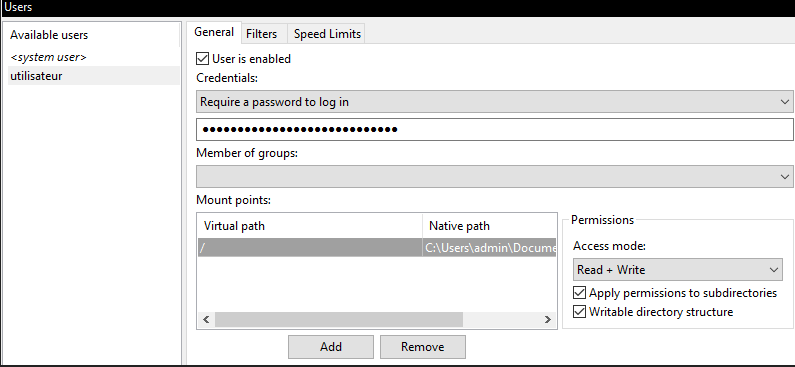

Création de l'utilisateur avec son mot de passe, ses droits et son repertoire d'accès (voir ci-dessus)

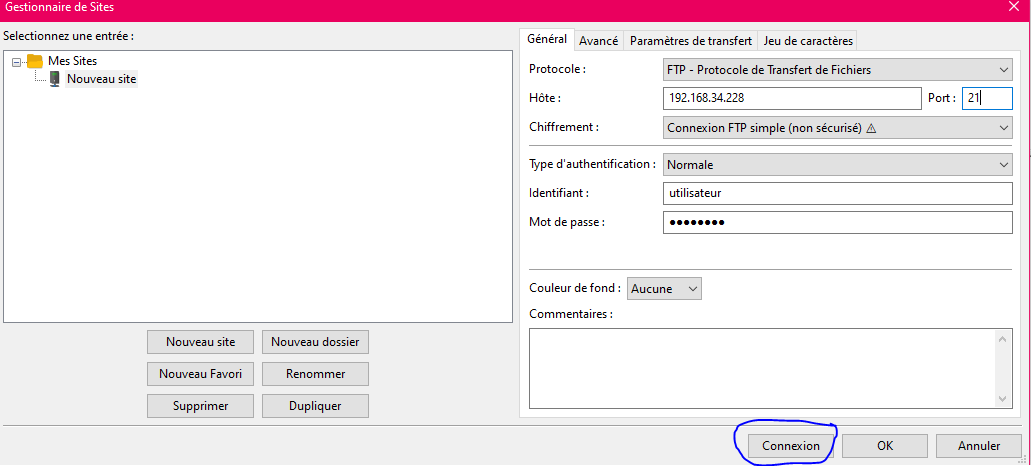

Connexion au serveur FTP depuis l'ordinateur client. Nous séléctionnons une connexion FTP non securisé afin de pouvoir 
intercepter les paquets.

<div class="alert alert-block alert-success">
Récupérer automatiquement le port TCP négocié et le nom du fichier</div>



Chaque fois que le port source est égale à 20 (FTP-DATA), nous allons stocker son port destination, qui est le port
négocié pour le transfert du fichier.

Concernant le nom du fichier, nous savons que dans une capture wireshark RETR est toujours suivis du nom du fichier, donc
nous allons afficher tout ce qui suit l'expression "RETR" dans nos paquets de données.

In [26]:
from scapy.all import * #librairie utile pour forger,analyser et sniffer des paquets
import re # regex va no


capture=rdpcap("McDiarmid.pcapng") #lire la capture McDiarmid.pcapng


for pkt in capture :     
     if pkt[TCP].sport == 20:  #si un paquet à un port source de 20
        portdest=pkt.dport   #k prends la valeur du port de destination
        
print(f"le numéro de port TCP négocié est {portdest}")

def fichiernom(capture): #fonction à appliquer à chaque paquet reçu dont on effectuera les traitements sur les paquets 
    raw = capture.sprintf('%Raw.load%') #charge les données bruts et va convertir les données brutes en string
    retr = re.findall('RETR (.*)', raw) #(.*) va afficher toutes les chaines de caractères qui suivent USER dans raw
    if retr: #si retr est vrai
        print("Le nom du fichier est :",retr)   
        
sniff(offline='McDiarmid.pcapng', prn =fichiernom)  #sniffe une capture en la traitant grâce à prn appelant la fonction fichiernom    


le numéro de port TCP négocié est 56236
Le nom du fichier est : ["attaque_sith.pdf\\r\\n'"]


<Sniffed: TCP:110 UDP:0 ICMP:0 Other:0>

<div class="alert alert-block alert-success">
Récupérer les informations en sniffant les paquets de l'interface réseau.</div>

Notre programme va sniffer l'interface réseau et va traiter les paquets en fonction de ce que nous avons définis sur la
fonction ftp.

Nous utilisons les mêmes commandes qu'auparavant pour afficher la suite de chaque expression (USER,PASS,RETR,226,PORT).


In [28]:
from scapy.all import * #librairie utile pour forger,analyser et sniffer des paquets
import re # regex va nous permettre d'analyser les expressions régulières

def ftp(packet): #fonction à appliquer à chaque paquet reçu dont on effectuera les traitements sur les paquets 
    raw = packet.sprintf('%Raw.load%') #charge les données bruts et va les affiher en string
    utilisateur = re.findall('USER (.*)', raw) #(.) va afficher toutes les chaines de caractères qui suivent USER dans raw
    mdp = re.findall('PASS (.*)', raw) #cherche toutes les occurences de PASS et affiche le contenu qui suit PASS
    retr = re.findall('RETR (.*)', raw) #cherche l'occurence RETR est toujours suivis du nom du fichier
    end = re.findall('226 (.*)', raw) #cherche le numéro 226 qui est le numéro de code indiquant un transfert terminé
    port = re.findall('PORT (.*)', raw) #cherche le numéro de port qui est affiché après l'occurence PORT
    if utilisateur:
        print("Le nom d'utilisateur est :",utilisateur) 
    elif mdp:
        print("Le mot de passe est :",mdp)
    elif retr:
        print("Le nom du fichier est",retr)        
    elif end:
        print("SUCCES ! :",end)
    elif port:
        k=str(port) #la valeur port obtenu est " ip1,ip2,ip3,ip4,p1,p2\\r\\n']"      Cela nous gène pour le calcul de p2.
        characters = "\\r\\n'" #défini les caractères spéciaux qu'on voudra supprimer à ce qui suit p2
        for x in range(len(characters)-1):
            k=k.replace(characters[x],"") #remplace "\\r\\n" par rien
        elements = k.split(",") #divise les éléments de la chaine de caractère en string, à chaque fois qu'une virgule apparait
        if len(elements)>1: 
            ip2=str(elements[5]) #ip2 prends la valeur d'une string 
            substract=re.sub('[^A-Za-z0-9]+','',ip2) #n'autorise que les numéros et soustrait donc le crochet
            numeroport=(int(elements[4])*256+int(substract)) #numéro de port est égale à
            print("le numéro de port est",numeroport) 
            fichier = open("monfichier.txt","wb") #ouvre le fichier en écritre de type bytes(octets)
            if packet[TCP].dport == numeroport: #si un packet tcp avec un port dest est égale au numéro de port obtenu
                 fichier.write(bytes(packet["Raw"])) #alors écris en octet dans le fichier les données
            fichier.close() #ferme le fichier
sniff (prn=ftp) #sniffe les paquets de l'interface réseau et les traite grâce à la fonction appelé dans prn

Le nom d'utilisateur est : ["utilisateur\\r\\n'"]
Le mot de passe est : ["password\\r\\n'"]
le numéro de port est 62927
Le nom du fichier est ["test.txt\\r\\n'"]
SUCCES ! : ["Operation successful\\r\\n'"]


<Sniffed: TCP:325 UDP:670 ICMP:0 Other:656>


Merci d'avoir lu notre NoteBook.

Faycal Lasri et Derouich Yassine.